<a href="https://colab.research.google.com/github/pareshrchaudhary/colab/blob/main/QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports


In [190]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from collections import deque
import matplotlib.pyplot as plt
import random

#Target Trajectory

torch.Size([65, 3])


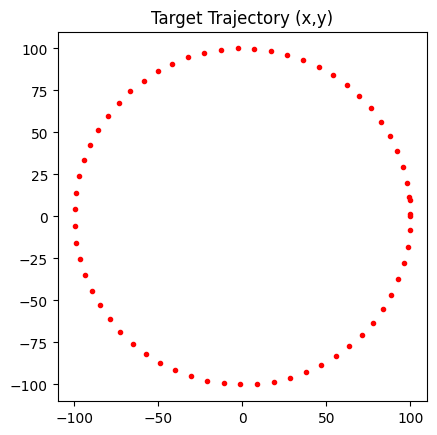

In [234]:
NTRAJSTEPS = 65 # no gap for dt = 0.1
dt = 0.1

target = torch.zeros((NTRAJSTEPS, 3))
targtrajarray = torch.arange(0.0, NTRAJSTEPS*dt, dt)

# Circle: compute positions
x = 100 * torch.cos(targtrajarray)
y = 100 * torch.sin(targtrajarray)

# Compute headings from positions
prevpos = torch.stack((x[:-2], y[:-2]), dim=1)
nextpos = torch.stack((x[2:], y[2:]), dim=1)
heading = nextpos - prevpos
theta = torch.atan2(heading[:, 1], heading[:, 0])

# Add heading for first and last position
theta = torch.cat((torch.tensor([torch.atan2(y[1] - y[0], x[1] - x[0])]), theta, torch.tensor([torch.atan2(y[-1] - y[-2], x[-1] - x[-2])])))

target = torch.cat((x.unsqueeze(1), y.unsqueeze(1), theta.unsqueeze(1)), dim=1)
print(target.shape)
plt.figure()
plt.plot(target[:, 0], target[:, 1], 'r.')
plt.axis('square')
plt.title('Target Trajectory (x,y)')
plt.show()

#Dynamics, Reward and other Functions 

In [227]:
## DO NOT ALTER ##
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0
dt = 0.02

In [282]:
class CarEnvironment:
    def __init__(self, dt=0.02):
        self.L = 1  # Length of the car
        self.dt = dt  # Time step
        self.done = False

    def car_dynamics(self, state, action):
        assert len(state) == 3, "state must be a tensor of shape (3,)"
        assert len(action) == 2, "action must be a tensor of shape (2,)"

        x, y, theta = state
        velocity, delta = action

        xnew = x + torch.cos(theta) * velocity * self.dt
        ynew = y + torch.sin(theta) * velocity * self.dt
        thetanew = theta + (velocity / self.L) * torch.tan(delta) * self.dt
        thetanew = thetanew % (2.0 * math.pi)
        new_state = torch.tensor([xnew, ynew, thetanew])
        return new_state

    def find_nearest(self, target, current):
        assert target.shape == torch.Size([65, 3]),  "target must be a (65,3) tensor"
        assert len(current) == 3, "state must be a tensor of shape (3,)"

        lookahead = 2
        x, y, theta = current

        inter_x = (target[:-lookahead-1, 0] - x)**2
        inter_y = (target[:-lookahead-1, 1] - y)**2
        dist = torch.sqrt(inter_x + inter_y)
        minindex = torch.argmin(dist)
        return minindex

    def calculate_deviation(self, mi, target, current):
        assert mi >= 0, "mi must be a non-negative integer"
        assert target.shape == torch.Size([65, 3]),  "target must be a (65,3) tensor"

        x, y, theta = current
        nearest_trajectory = torch.stack((target[mi, 0] - x, target[mi, 1] - y), dim=0)

        car_xvec = torch.cos((math.pi/2.0) + theta)
        car_yvec = torch.sin((math.pi/2.0) + theta)
        carLeftvec = torch.stack((car_xvec, car_yvec), dim=0)

        error = -torch.dot(nearest_trajectory, carLeftvec)
        return error

    def calculate_reward(self, state, target):
        assert len(state) == 3, "state must be a tensor of shape (3,)"
        assert target.shape == torch.Size([65, 3]),  "target must be a (65,3) tensor"

        nearest_index = self.find_nearest(target, state)
        deviation_error = self.calculate_deviation(nearest_index, target, state)

        if deviation_error >= 0:
            reward = 1.0
        else:
            reward = -1.0

        return reward

    def step(self, state, action, target):
      next_state = self.car_dynamics(state, action)
      reward = self.calculate_reward(state, target)

      index = self.find_nearest(target, state) # Termination
      if (index == 65):
        self.done = True

      return next_state, reward, self.done

In [281]:
# Create an instance of CarEnvironment
env = CarEnvironment()

# Define a state, action, and target tensors
state = torch.tensor([0.0, 0.0, 0.0])
action = torch.tensor([1.0, 0.1])
target = torch.randn(65, 3)

# Calculate the reward
reward = env.calculate_reward(state, target)
print("Reward:", reward)

# Perform a step in the environment
next_state, reward, done = env.step(state, action, target)
print("Next state:", next_state)
print("Reward:", reward)
print("Done:", done)

Reward: 1.0
Next state: tensor([0.0200, 0.0000, 0.0020])
Reward: 1.0
Done: False


#Deep Q Network 

In [191]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, action_dim)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        q_values = self.fc6(x)
        return q_values

    def initialize_weights(self):
      for module in self.modules():
        if isinstance(module, nn.Linear):
          nn.init.xavier_uniform_(module.weight.data)
          nn.init.constant_(module.bias.data, 0.0)

In [216]:
#model test
state_dim = 3
action_dim = 2
dqn = DQN(state_dim, action_dim)
dqn

DQN(
  (fc1): Linear(in_features=3, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (fc5): Linear(in_features=64, out_features=32, bias=True)
  (fc6): Linear(in_features=32, out_features=2, bias=True)
)

In [259]:
dqn.initialize_weights()
sample_state = torch.tensor([1.0, 2.0, 0.5])  # Example input state

q_values = dqn.forward(sample_state)
print(q_values)

tensor([0.3208, 0.2081], grad_fn=<AddBackward0>)


# Experience Play - ReplayBuffer

In [339]:
class ReplayBuffer():
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = []

    def add_experience(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.buffer.append(experience)
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)

    def sample_batch(self, batch_size):
        if len(self.buffer) < batch_size:
            return None  # Return None if buffer does not have enough samples

        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.buffer)

In [333]:
# Test buffer
buffer = ReplayBuffer(buffer_size=1000)

# Add experiences to the buffer
state = torch.tensor([1.0, 2.0, 0.5])  # Example state
action =  torch.tensor([0.1909, -0.0496])  # Example action
reward = 0.1  # Example reward
next_state = torch.tensor([1.2, 2.1, 0.6])  # Example next state
done = False  # Example done flag
buffer.add_experience(state, action, reward, next_state, done)

# Sample a batch from the buffer
batch_size = 1
states, actions, rewards, next_states, dones = buffer.sample_batch(batch_size)

# Check the length of the buffer
buffer_length = len(buffer)

print("States:", states)
print("Actions:", actions)
print("Rewards:", rewards)
print("Next States:", next_states)
print("Dones:", dones)
print("Buffer Length:", buffer_length)

States: (tensor([1.0000, 2.0000, 0.5000]),)
Actions: (tensor([ 0.1909, -0.0496]),)
Rewards: (0.1,)
Next States: (tensor([1.2000, 2.1000, 0.6000]),)
Dones: (False,)
Buffer Length: 1


In [341]:
test = ReplayBuffer(buffer_size=1000)

for i in range(0, 32):
  state = torch.tensor([1.0, 2.0, 0.5])  # Example state
  action =  torch.tensor([0.1909, -0.0496])  # Example action
  reward = 0.1  # Example reward
  next_state = torch.tensor([1.2, 2.1, 0.6])  # Example next state
  done = False  # Example done flag
  test.add_experience(state, action, reward, next_state, done)

batch_size = 32
batch = test.sample_batch(batch_size)
print(len(test))
print(batch)
# states, actions, rewards, next_states, dones = buffer.sample_batch(batch_size)

32
((tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1.0000, 2.0000, 0.5000]), tensor([1

# Q Learning Functions

In [476]:
# Q Learning Functions
def choose_action(state, q_net, epsilon):
    if torch.rand(()) < epsilon: # Explore (choose a random action)
        action = torch.randn(2)
    else:
      with torch.no_grad():      # Exploit (choose the action with the maximum Q-value)
        q_values = q_values = q_net(state.clone().detach().requires_grad_(True))  
        index = torch.argmin(q_values)
        action = q_values.clone().detach()
        action[index] = 0.0
    return action

In [477]:
choose_action(state, dqn, 0.95)

tensor([0.0000, 0.4149])

#Training

In [480]:
# Environment parameters
dt = 0.02
env = CarEnvironment(dt)
initial_state = torch.tensor([100.0, 0.0, 90.0 * deg2rad])
rad2deg = 180.0 / np.pi
deg2rad = np.pi / 180.0

# Q-Network
state_dim = 3
action_dim = 2
dqn = DQN(state_dim, action_dim)
dqn.initialize_weights()
target_network = DQN(state_dim, action_dim)
target_network.load_state_dict(dqn.state_dict())
target_network.eval()
optimizer = torch.optim.Adam(dqn.parameters(), lr=0.001)

# Experience Replay - Buffer
buffer_size = 10000
batch_size = 32
replay_buffer = ReplayBuffer(buffer_size)

# Training Loop Parameters
num_episodes = 1000
drivestep = 320

learning_rate = 0.001
epsilon = 1.0  # Initial exploration rate
epsilon_decay = 0.995  # Decay rate of exploration rate
epsilon_min = 0.01  # Minimum exploration rate
gamma = 0.99  # Discount factor

In [482]:
for episode in range(0,num_episodes):
  state = initial_state
  total_reward = 0
  target_update_interval = 100
  for t in range(0,drivestep):
    action = choose_action(state, dqn, epsilon)
    next_state, reward, done = env.step(state, action, target)
    # print("State: ", state, "Action: ", action,"Reward: ", reward, "Next State: ", next_state, "Done: ", done)
    replay_buffer.add_experience(state, action, reward, next_state, done)

    if len(replay_buffer) >= batch_size:
      # mini_batch of experiences
      states, actions, rewards, next_states, dones = replay_buffer.sample_batch(batch_size)
      # Convert the lists to PyTorch tensors
      states = torch.stack(states)
      actions = torch.stack(actions)
      rewards = torch.tensor(rewards, dtype=torch.float32)
      next_states = torch.stack(next_states)
      dones = torch.tensor(dones, dtype=torch.bool)
      # print("\nStates: ", states, "\nActions: ", actions,"\nRewards: ", rewards, "\nNext States: ", next_states, "\nDones: ", dones)
      
      # Compute target Q-values
      with torch.no_grad():
          target_q_values = target_network(next_states)
          print("target_q_values = ", target_q_values.shape)
          target_q_values = torch.max(target_q_values, dim=1)[0]  # Take the maximum Q-value for each next state
          
          target_q_values[dones] = 0  # Set target Q-values to 0 for terminal states
          target_q_values = rewards + gamma * target_q_values


      # Compute current Q-values
      predicted_q_values = dqn(states)
      print("predicted_q_values = ", predicted_q_values.shape)
      # Convert the actions tensor to long data type
      actions = actions.long()  # Convert actions to torch.long data type
      predicted_q_values = predicted_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

      # Compute the loss function
      loss = F.smooth_l1_loss(predicted_q_values, target_q_values)

      # Perform Optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Update the current state
      state = next_state
      total_reward += reward

      # Update the target network periodically
      if t % target_update_interval == 0:
          target_network.load_state_dict(dqn.state_dict())

    # Update exploration parameter
    print(f"Episode: {episode+1}, Total Reward: {total_reward}")
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # Check if the episode is done
    if done:
        break


target_q_values =  torch.Size([32, 2])
predicted_q_values =  torch.Size([32, 2])


RuntimeError: ignored

# Test

tensor([100.0000,   0.0000,   1.5708])


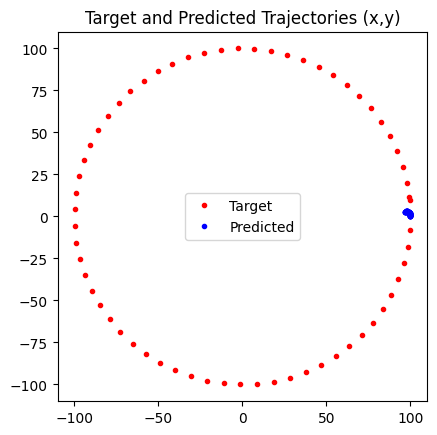

torch.Size([65, 3])


In [439]:
NTRAJSTEPS = 65
dt = 0.1

target = torch.zeros((NTRAJSTEPS, 3))
targtrajarray = torch.arange(0.0, NTRAJSTEPS * dt, dt)

# Circle: compute positions
x = 100 * torch.cos(targtrajarray)
y = 100 * torch.sin(targtrajarray)

# Compute headings from positions
prevpos = torch.stack((x[:-2], y[:-2]), dim=1)
nextpos = torch.stack((x[2:], y[2:]), dim=1)
heading = nextpos - prevpos
theta = torch.atan2(heading[:, 1], heading[:, 0])

# Add heading for first and last position
theta = torch.cat((torch.tensor([torch.atan2(y[1] - y[0], x[1] - x[0])]), theta, torch.tensor([torch.atan2(y[-1] - y[-2], x[-1] - x[-2])])))

target = torch.cat((x.unsqueeze(1), y.unsqueeze(1), theta.unsqueeze(1)), dim=1)

# Initialize the current state
state = initial_state
print(state)

# Generate predicted trajectory
predicted_trajectory = []
for t in range(NTRAJSTEPS):
    # Choose an action based on the current state
    action = dqn(state)
    
    # Take a step in the environment
    next_state, reward, done  = env.step(state, action, target)
    
    # Add the state to the predicted trajectory
    predicted_trajectory.append(state)
    
    # Update the current state
    state = next_state

# Convert the predicted trajectory to a tensor
predicted_trajectory = torch.stack(predicted_trajectory)

# Plot the target and predicted trajectories
plt.figure()
plt.plot(target[:, 0], target[:, 1], 'r.', label='Target')
plt.plot(predicted_trajectory[:, 0], predicted_trajectory[:, 1], 'b.', label='Predicted')
plt.axis('square')
plt.title('Target and Predicted Trajectories (x,y)')
plt.legend()
plt.show()
